In [1]:
import torch
from torch_geometric.datasets import TUDataset, Entities
import torch
# from tqdm import tqdm
from torch_geometric.utils import to_networkx
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from gnn import GNN
import matplotlib.pyplot as plt
import os
import numpy as np
from gnn import GNN
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.data import Data, Batch
import plotly.express as px
import matplotlib.colors as mcolors
import random
import pickle
from utils import draw_graph, get_average_phi
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import pandas as pd

if not os.path.isdir("figures"): os.mkdir("figures")

import plotly.io as pio
pio.templates.default = "simple_white"

In [2]:
atom_indices = {
    0: "C",
    1: "N",
    2: "O",
    3: "F",
    4: "I",
    5: "Cl",
    6: "Br",
}

edge_indices = {
    0: "aromatic",
    1: "single",
    2: "double",
    3: "triple",
}

atom_colors = {
    0: "#9b5fe0",
    1: "#16a4d8",
    2: "#60dbe8",
    3: "#efdf48",
    4: "#f9a52c",
    5: "#d64e11",
    6: "#8bd346",
}

In [3]:
# model_path = "models/Shapes_model.pth"
# with open("data/Shapes/dataset.pkl", "rb") as f: dataset = pickle.load(f)
# molecules = False

model_path = "models/MUTAG_model.pth"
dataset = TUDataset(root='data/TUDatascet', name='MUTAG')
molecules = True

# model_path = "models/OurMotifs_model_mean.pth"
# with open("data/OurMotifs/dataset.pkl", "rb") as f: dataset = pickle.load(f)
# molecules = False

# model_path = "models/Is_Acyclic_model.pth"
# with open("data/Is_Acyclic/dataset.pkl", "rb") as f: dataset = pickle.load(f)
# molecules = False

In [4]:
num_node_features = dataset[0].x.shape[1]
node_colors = {i:c for i,c in enumerate(random.choices(list(mcolors.CSS4_COLORS.values()), k=num_node_features))}
node_colors

{0: '#98FB98',
 1: '#FFA07A',
 2: '#87CEFA',
 3: '#6B8E23',
 4: '#FFFFFF',
 5: '#FF0000',
 6: '#40E0D0'}

In [5]:
import os
os.listdir("models/")

['Shapes_Clean_model_small.pth',
 'OurMotifs_model_mean.pth',
 'Shapes_Clean_problem_model.pth',
 'Shapes_Clean_model_sum.pth',
 'OurMotifs_model.pth',
 'Is_Acyclic_model.pth',
 'Shapes_model.pth',
 'Shapes_Clean_model.pth',
 'MUTAG_model.pth',
 'wrapped_MUTAG_model.pth']

In [6]:
nn = torch.load(model_path)
nn.double()
nn.eval()

GNN(
  (layers): ModuleDict(
    (Conv_0): SAGEConv(7, 64, aggr=sum)
    (Conv_0_Relu): ReLU()
    (Conv_1): SAGEConv(64, 32, aggr=sum)
    (Conv_1_Relu): ReLU()
    (Aggregation): MeanAggregation()
    (Lin_0): Linear(in_features=32, out_features=16, bias=True)
    (Lin_0_Relu): ReLU()
    (Lin_1): Linear(in_features=16, out_features=8, bias=True)
    (Lin_1_Relu): ReLU()
    (Output): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [7]:
phi = get_average_phi(dataset, nn, "Aggregation")

In [8]:
with open("solutions.pkl", "rb") as f:
    solutions = pickle.load(f)

In [9]:
list(solutions[-1].keys())

['X',
 'A',
 'Output',
 'time',
 'Objective Value',
 'Upper Bound',
 'Variables Changed',
 'Changed Variables']

In [19]:
[name for name, old, new in solutions[-1]["Changed Variables"] if np.abs(old-new) > 0.00001]

[]

NN output given explanation [-6.41946108  4.0929635  -2.8094771   2.48543841  2.1502476 ]


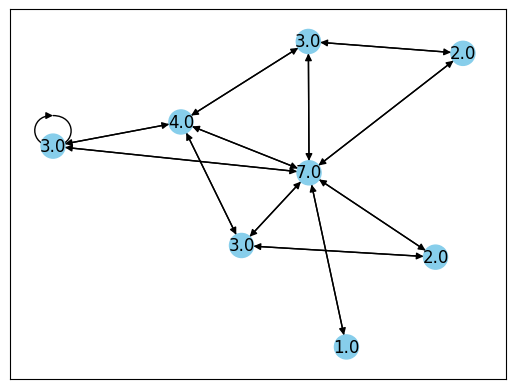

In [10]:
# index = "Final"
# A = np.load(f"./solutions/A_{index}.npy")
# X = np.load(f"./solutions/X_{index}.npy")
final = solutions[-1]
A = final["A"]
X = final["X"]


fig, _ = draw_graph(A, X, label_dict=(atom_indices if molecules else None), color_dict=(atom_colors if molecules else None))
fig.show()

exp_output = nn.forwardXA(X, A).detach().numpy().squeeze()
print("NN output given explanation", exp_output)


In [11]:
plt.close()

0


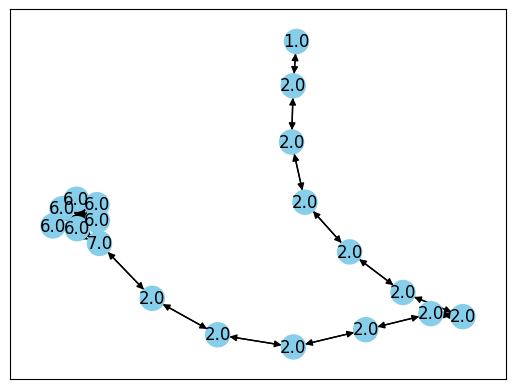

0


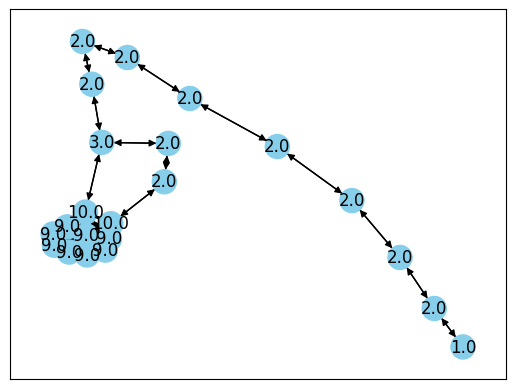

0


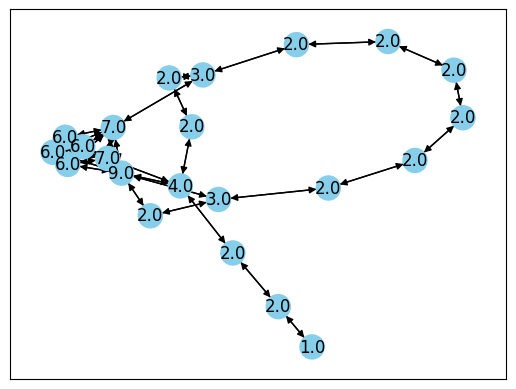

0


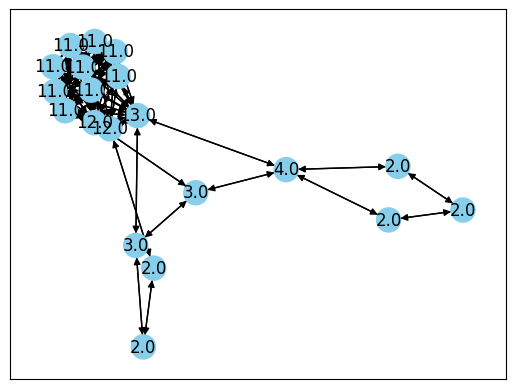

0


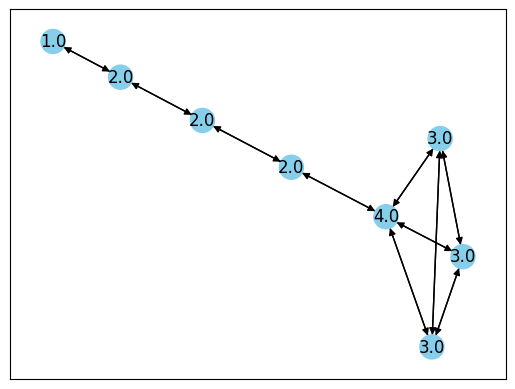

0


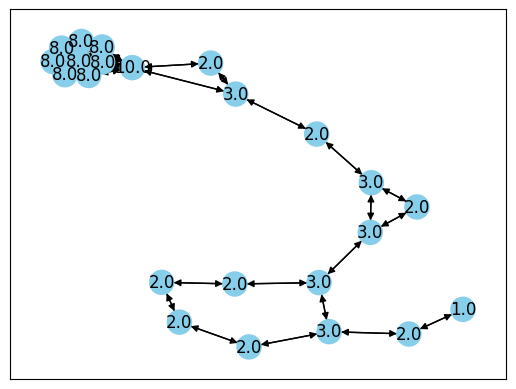

0


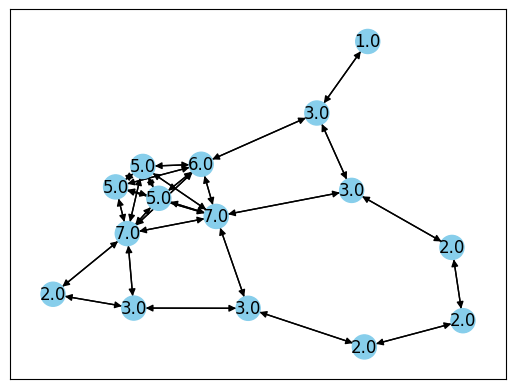

0


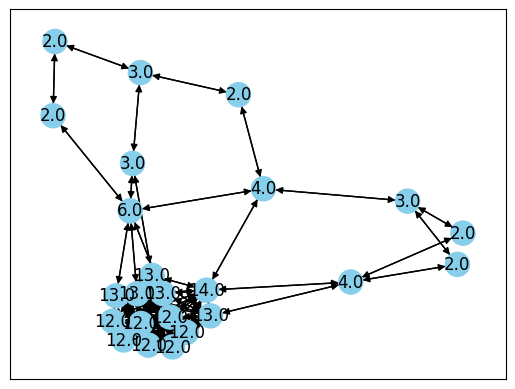

0


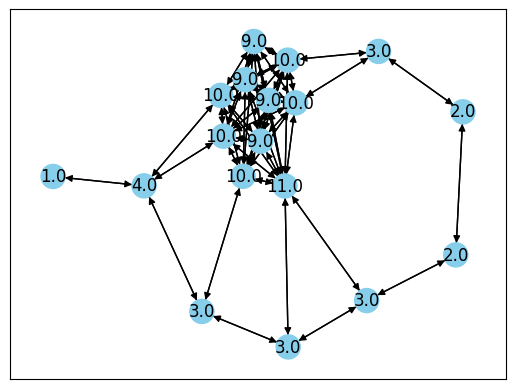

0


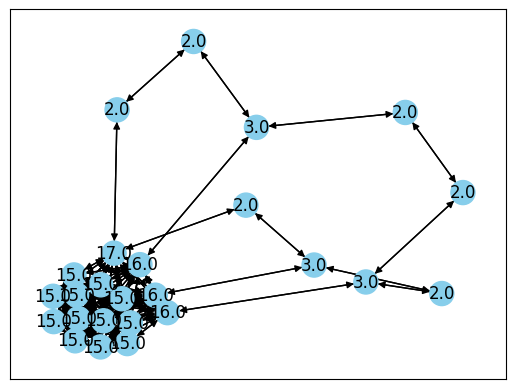

In [12]:
for data in [d for d in dataset if d.y==0][:10]:
    print(data.y)
    fig, ax = draw_graph(to_dense_adj(data.edge_index)[0].detach().numpy(), data.x.detach().numpy(), color_dict=(atom_colors if molecules else None), label_dict=(atom_indices if molecules else None))
    plt.show()
    fig.clear()

In [13]:
from gnn import GNN
class WrappedGNN(torch.nn.Module):
    def __init__(self, gnn):
        super().__init__()
        self.gnn = gnn
    
    def forward(self, x, edge_index):
        return self.gnn.forward(Data(x=x, edge_index=edge_index))
    
wrapped_nn = WrappedGNN(nn)
wrapped_nn.double()

torch.save(nn, "models/wrapped_MUTAG_model.pth")

In [14]:
# from torch_geometric.data import Data, DataLoader
# from torch_geometric.explain import Explainer, PGExplainer, GNNExplainer

# loader = DataLoader(dataset, batch_size=1, shuffle=True)

# explainer = Explainer(
#     model=wrapped_nn,
#     algorithm=GNNExplainer(epochs=200),
#     explanation_type='model',
#     node_mask_type='attributes',
#     edge_mask_type='object',
#     model_config=dict(
#         mode='multiclass_classification',
#         task_level='graph',
#         return_type='log_probs',
#     ),
#     # Include only the top k most important edges:
#     threshold_config=dict(threshold_type='topk', value=5),
# )

# # Generate the explanation for a particular graph:
# explanation = explainer(x=torch.Tensor(X).double(), edge_index=dense_to_sparse(torch.Tensor(A))[0])
# # print(explanation.edge_mask)
# # print(explanation.node_mask)

# explanation.visualize_graph()

In [15]:
import networkx.algorithms.isomorphism as iso
hypothesis_graph = nx.Graph()
# hypothesis_graph_nodes = [(0, {"label": 0}), (1, {"label": 0}), (2, {"label": 0}), (3, {"label": 0}), (4, {"label": 0}), (5, {"label": 0})]
# hypothesis_graph_nodes += [(6, {"label": 0}), (7, {"label": 0}), (8, {"label": 0}), (9, {"label": 0}), (10, {"label": 0}), (11, {"label": 0})]
hypothesis_graph_nodes = [(0, {"label": 4})]
hypothesis_graph.add_nodes_from(hypothesis_graph_nodes)
# hypothesis_graph.add_edges_from([(i,i+1) for i in range(0, 5)] + [(5,0)])
# hypothesis_graph.add_edges_from([(i,i+1) for i in range(6, 11)] + [(11,6)])
# hypothesis_graph.add_edge(0, 1)
# hypothesis_graph.add_edge(1, 2)
num_classes = len(set([int(d.y) for d in dataset]))
total = [0 for _ in range(num_classes)]
total_matched = [0 for _ in range(num_classes)]
for data in tqdm(dataset):
    # print(data.x)
    data_graph = to_networkx(data, to_undirected=True)
    x_indices = np.argmax(data.x.detach().numpy(), axis=1)
    if 4 in x_indices: print("hello")
    label_mapping = dict(zip(range(data.x.shape[0]), x_indices)) # dict(zip(range(X.shape[0]), map(label_dict.get, x_indices)))
    nx.set_node_attributes(data_graph, label_mapping, "label")
    GM = iso.GraphMatcher(data_graph,hypothesis_graph, node_match=iso.categorical_node_match('label',None))
    total[data.y] += 1
    total_matched[data.y] += GM.subgraph_is_isomorphic()
print(total, total_matched, [a/b for a,b in zip(total_matched, total)])

# print({key: torch.eye(7)[value["label"]] for key, value in hypothesis_graph_nodes})
# nx.set_node_attributes(hypothesis_graph, {key: torch.eye(7)[value["label"]] for key, value in hypothesis_graph_nodes}, name="label")

# for data in tqdm(dataset):
#     data.x = data.x.double()
#     original_prediction = nn(data).detach().numpy().squeeze()
#     del data.edge_weight
#     del data.batch

#     data_graph = to_networkx(data, to_undirected=True)
#     label_mapping = dict(zip(range(data.x.shape[0]), list(data.x)))
#     nx.set_node_attributes(data_graph, label_mapping, "label")
#     updated_graph = nx.union(data_graph, hypothesis_graph, rename=("h", "g"))
#     data = from_networkx(updated_graph, group_node_attrs=["label"])

#     # data.edge_index = torch.cat([data.edge_index, torch.Tensor([[random.choice(range(data.x.shape[0])), data.x.shape[0]]]).int().T], axis=1)
#     # data.x = torch.cat([data.x, torch.unsqueeze(torch.eye(data.x.shape[1])[4],axis=0)], axis=0)
#     new_prediction = nn(data).detach().numpy().squeeze()

#     print(original_prediction - new_prediction)
#     print("--")
# print(total, total_matched)

  0%|          | 0/8000 [00:00<?, ?it/s]

[1590, 1640, 1606, 1611, 1553] [0, 0, 0, 0, 0] [0.0, 0.0, 0.0, 0.0, 0.0]


In [18]:
all_outputs = []
max_output_value, min_output_value = None, None
max_activation_value = -float("inf")
num_nodes = []

for max_class in [1]:#range(num_classes):
    similarities = []
    for i, data in enumerate(dataset):
        data.x = data.x.double()
        outputs = nn(data).detach().numpy()
        # if outputs[0][0] < -15: print(i)
        all_outputs.append(outputs)
        if max_output_value is None: max_output_value, min_output_value = -float("inf")*np.ones_like(outputs), float("inf")*np.ones_like(outputs)
        max_output_value = np.max(np.stack([max_output_value, outputs]),axis=0)
        min_output_value = np.min(np.stack([min_output_value, outputs]),axis=0)

        all_layer_outputs = nn.get_all_layer_outputs(data)
        embedding = dict(all_layer_outputs)["Aggregation"].detach().numpy()
        l1_similarity = sum(np.abs((embedding[0] - phi[max_class])))
        squared_l2_similarity = sum((embedding[0] - phi[max_class])*(embedding[0] - phi[max_class]))
        cosine_similarity = np.dot(embedding[0], phi[max_class])/(np.linalg.norm(embedding[0])*np.linalg.norm(phi[max_class]))
        dot_product = np.dot(embedding[0], phi[max_class])
        similarities.append({"L1": l1_similarity, "Squared L2": squared_l2_similarity, "L2": np.sqrt(squared_l2_similarity),"Cosine": cosine_similarity, "Dot Product": dot_product, "Class": int(data.y)})

        all_activations = [output for _, output in all_layer_outputs]
        max_activation_value = max(max_activation_value, max(float(torch.max(torch.abs(activation))) for activation in all_activations))
        num_nodes.append(data.num_nodes)
    print("Max Absolute Activation Value:", max_activation_value)
    print("Min Class Output Value:", min_output_value)
    print("Max Class Output Value:", max_output_value)

    similarities = pd.DataFrame.from_records(similarities)
    for similarity in similarities.columns:
        if similarity == "Class": continue
        px.violin(similarities, x=similarity, color="Class", color_discrete_map={0: "Red", 1: "Blue"}, title=f"{similarity} Similarity to Phi[{max_class}] of Class {max_class}", box=True).show()
px.histogram(num_nodes, title="Number of Nodes").show()


all_outputs = np.concatenate(all_outputs, axis=0)
px.scatter(x=list(all_outputs[:, 1])+[exp_output[1]], y=list(all_outputs[:, 3])+[exp_output[3]], color=[str(int(d.y)) for d in dataset]+["2"], color_discrete_map={"0": "Red", "1": "Blue", "2": "Green"}).show()
for i in range(all_outputs.shape[-1]):
    fig = px.histogram(all_outputs[:, i], title=f"Class {i} Logit Distribution", color=[int(d.y) for d in dataset], color_discrete_map={0: "Red", 1: "Blue"}, marginal="box")

    # fig.add_annotation(
    #     text="Explanation Value",
    #     x=exp_output[i],
    #     y=0,  # Adjust the y-coordinate as needed
    #     showarrow=True,
    #     arrowhead=2,
    #     ax=0,  # Adjust the text label's position relative to the point
    #     font=dict(
    #         size=14,
    #     )
    # )

    # fig.update_layout(
    #     xaxis_title="Logit Value",
    #     yaxis_title="Count",
    # )

    # fig.update_xaxes(
    #     range=[min(min(all_outputs[:, i]), exp_output[i])-2, max(max(all_outputs[:, i]), exp_output[i])+2]
    # )    

    fig.show()

Max Absolute Activation Value: 181.96118419394458
Min Class Output Value: [[-181.96118419   -6.8265655   -49.69337495  -27.77043231   -1.83113886]]
Max Class Output Value: [[ 14.58695571  79.89339954   5.11685759 115.66383942  27.4440121 ]]


all_outputs shape: (8000, 5)


In [17]:
folder = "figures"
# for i in range(14):
#     A = np.load(f"./solutions/A_{i}.npy")
#     X = np.load(f"./solutions/X_{i}.npy")
for i, sol in enumerate(solutions):
    A = sol["A"]
    X = sol["X"]

    fig, _ = draw_graph(A, X, label_dict=(atom_indices if molecules else None), color_dict=(atom_colors if molecules else None))
    
    plt.savefig(folder + "/file%02d.png" % i)
    plt.close()

import subprocess
import glob
os.chdir(folder)
subprocess.call([
    'ffmpeg', '-framerate', '4', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p', '-y',
    'graph_steps.mp4'
])
for file_name in glob.glob("*.png"):
    os.remove(file_name)
os.chdir("..")

ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvo